In [1]:
import torch as pt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

from dataset import RealSRV3

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = "cuda" if pt.cuda.is_available() else "cpu"
batch_size = 64
gen_lr = 2e-4
disc_lr = 2e-4
epochs = 50
low_stats = (0, 0, 0), (1, 1, 1)
high_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
dataset = RealSRV3("/mnt/d/Datasets/RealSR(V3)")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

self.class_names[-1]: /mnt/d/Datasets/RealSR(V3)/Nikon/Train/4


In [4]:
def denorm(img_tensors, img_type="low"):
    if img_type == "low":
        return img_tensors * low_stats[1][0] + low_stats[0][0]
    else:
        return img_tensors * high_stats[1][0] + high_stats[0][0]

In [5]:
def show_images(images, n_max=batch_size):
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:n_max]), nrow=8).permute(1, 2, 0))

In [6]:
from generator import Generator
from discriminator import Discriminator
from loss import VGGLoss

images.shape: torch.Size([64, 3, 24, 24])


/home/parth/miniconda3/envs/env-pytorch/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


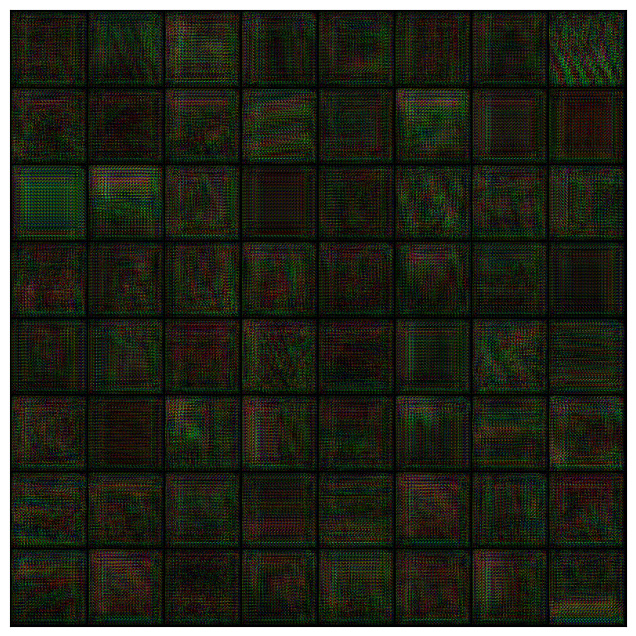

In [7]:
generator = Generator(upscale_factor=4).to(device)

for low_res_images, _ in loader:
    print(f"images.shape: {low_res_images.shape}")
    fake_images = generator(low_res_images.to(device))
    break
show_images(fake_images)

In [ ]:
discriminator = Discriminator(upscale_factor=4).to(device)

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = pt.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator.train()(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = pt.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator.train()(real_images)
    real_targets = pt.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # real_score = pt.mean(real_preds).item()

    # Generate fake images
    latent = pt.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator.train()(latent)

    # Pass fake images through discriminator
    fake_targets = pt.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator.train()(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    # fake_score = pt.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss # (... + ...) / 2
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.detach().cpu().item(), fake_loss.detach().cpu().item() # real_score, fake_score

In [ ]:
import os

sample_dir = 'generated-images'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator.eval()(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(
        denorm(fake_images.detach().cpu()),
        os.path.join(sample_dir, fake_fname),
        nrow=8
    )
    print('Saving', fake_fname)
    if show:
        _, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.detach().cpu(), nrow=8).permute(1, 2, 0))
        plt.show()

In [ ]:
opt_g = pt.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
opt_d = pt.optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))

In [ ]:
import numpy as np
from tqdm import tqdm

In [ ]:
losses_g, losses_d = [], []
real_scores, fake_scores = [], []

for epoch in range(epochs):
    batch_loss_g, batch_loss_d = [], []
    batch_real_score, batch_fake_score = [], []

    for loader in train_loader, test_loader:
        # Train discriminator
        for real_images, _ in tqdm(loader):
            loss_d, real_score, fake_score = train_discriminator(real_images.to(device), opt_d)
            batch_loss_d.append(loss_d)
            batch_real_score.append(real_score)
            batch_fake_score.append(fake_score)
            # Train generator
            loss_g = train_generator(opt_g)
            batch_loss_g.append(loss_g)

    # Record losses & scores
    losses_g.append(np.mean(batch_loss_g))
    losses_d.append(np.mean(batch_loss_d))
    real_scores.append(np.mean(batch_real_score))
    fake_scores.append(np.mean(batch_fake_score))

    batch_loss_g, batch_loss_d = [], []
    batch_real_score, batch_fake_score = [], []

    # Save generated images
    save_samples(epoch+1, fixed_latent, show=False)

    # Log losses & scores (last batch)
    print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f},"
          + f" real_score: {real_score:.4f}, fake_score: {fake_score:.4f}\n")

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)

plt.subplot(2, 2, 1)
plt.plot(losses_g, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')

plt.subplot(2, 2, 2)
plt.plot(losses_d, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')

plt.subplot(2, 2, 3)
plt.plot(real_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Real Images Discriminator Scores')

plt.subplot(2, 2, 4)
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Fake Images Discriminator Scores')

In [ ]:
pt.save(generator.state_dict(), "models/generator-model")
pt.save(discriminator.state_dict(), "models/discriminator-model")